In [30]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [31]:
# Parameters
max_words = 10000  # Top 10,000 most frequent words
max_len = 200      # Maximum sequence length

# Load the dataset
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words)

# Convert word indices back to text for TF-IDF
word_index = reuters.get_word_index()
index_to_word = {v: k for k, v in word_index.items()}

def indices_to_text(indices):
    return ' '.join([index_to_word.get(i, '') for i in indices if i in index_to_word])

# Convert training and test data to text
x_train_text = [indices_to_text(seq) for seq in x_train]
x_test_text = [indices_to_text(seq) for seq in x_test]

# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=max_words, max_df=0.95, min_df=2)
x_train_tfidf = vectorizer.fit_transform(x_train_text).toarray()
x_test_tfidf = vectorizer.transform(x_test_text).toarray()

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=46)
y_test = to_categorical(y_test, num_classes=46)

print(f"Training data shape (TF-IDF): {x_train_tfidf.shape}")
print(f"Test data shape (TF-IDF): {x_test_tfidf.shape}")

Training data shape (TF-IDF): (8982, 9536)
Test data shape (TF-IDF): (2246, 9536)


In [51]:
# Model parameters for fine-tuning
num_units = [256, 256, 64]  # Increased capacity
num_layers = len(num_units)
dropout_rate = 0.3           # Reduced dropout
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate
batch_size = 64              # Increased batch size
epochs = 15                # More epochs with early stopping
validation_split = 0.2
l2_reg = keras.regularizers.l2(0.001)  # Reduced regularization

# Initialize the model
model = Sequential()

# Input layer
model.add(Dense(num_units[0], input_shape=(x_train_tfidf.shape[1],), activation='relu', kernel_regularizer=l2_reg))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden layers
for units in num_units[1:]:
    model.add(Dense(units, activation='relu', kernel_regularizer=l2_reg))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(46, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │     2,441,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,529,006 (9.65 MB)

 Trainable params: 2,527,854 (9.64 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train_tfidf, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.1011 - loss: 4.7944 - val_accuracy: 0.0028 - val_loss: 4.7126
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4585 - loss: 3.1931 - val_accuracy: 0.0028 - val_loss: 4.4705
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6170 - loss: 2.5506 - val_accuracy: 0.3467 - val_loss: 3.9377
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7198 - loss: 2.1589 - val_accuracy: 0.6277 - val_loss: 3.2273
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7698 - loss: 1.9265 - val_accuracy: 0.7329 - val_loss: 2.5248
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7950 - loss: 1.7620 - val_accuracy: 0.7618 - val_loss: 2.0562
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ -1s -11822us/step - accuracy: 0.8297 - loss: 1.6096 - val_accuracy: 0.7824 - val_loss: 1.8724
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8522 - loss: 1.4775 - val

In [53]:
test_loss, test_accuracy = model.evaluate(x_test_tfidf, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.7251
Test Accuracy: 0.7921


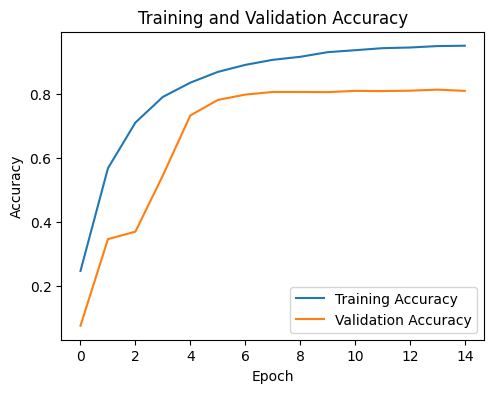

In [39]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

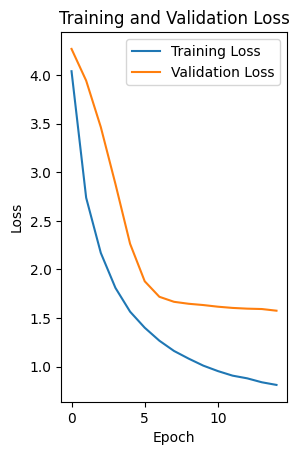

In [40]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()